<a href="https://colab.research.google.com/github/CherylA24/Dog-CatRecognizer/blob/main/dog_n_cat_classifier_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cheryl Angelica - 2301855854**

In [ ]:
# I install this version opencv to run SIFT 

!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 30.6 MB 1.2 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


--> Import Necessary Library

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import os
from scipy.cluster.vq import kmeans, vq
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sn

1. Selecting representative images from an image dataset (https://www.kaggle.com/c/dogs-vs-cats/)

In [ ]:
# Load Train Dataset and Define img_list and label category

image_path = "dataset/train/"
img_list = []
label = []

for img in os.listdir(image_path):
  if img.endswith('jpg'):
    img_path = os.path.join(image_path, img)
    category = img.split('.')[0]
    label.append(category)
    img_list.append(img_path)

In [ ]:
# Check the data and the category related

import pandas as pd
df = pd.DataFrame({
    'filename': img_list,
    'category': label
})

df.head()

,filename,category
0,dataset/train/cat.661.jpg,cat
1,dataset/train/dog.347.jpg,dog
2,dataset/train/dog.633.jpg,dog
3,dataset/train/dog.314.jpg,dog
4,dataset/train/dog.398.jpg,dog


2. Split the data into *X_train, X_test, y_train, y_test*

In [ ]:
# Split the data (I split it into 20% of test data and 80% of train data)

X_train, X_test, y_train, y_test = train_test_split(img_list, label, test_size=0.2, random_state=42)

3.	Collect all the SIFT descriptors from the images in 1 array

In [ ]:
SIFT = cv.xfeatures2d.SIFT_create()
desc_list = []

for image in X_train:
  _, desc = SIFT.detectAndCompute(cv.imread(image), None)
  desc_list.append(desc)

4.	Cluster these descriptors using K Means into k number of clusters where k is a number i set. The center of these clusters are the "visual words" i.e. representative features in your database of images.

In [ ]:
k = 100

descriptors = desc_list[0][1]
for desc in desc_list[1:]:
  descriptors = np.vstack((descriptors, desc))

centroids, _ = kmeans(descriptors, k, 1)

5. Create a vector V that counts how frequently the different features in the dictionary occurs

In [ ]:
vector = np.zeros((len(X_train), k), "float32")

for i in range(len(X_train)):
  words, _ = vq(desc_list[i], centroids)
  for w in words:
    vector[i][w] += 1

counter = np.sum((vector > 0) * 1, axis= 0)
df = np.array(np.log((1.0 * len(X_train) +1 )/(1.0 * counter + 1)), 'float64')

freq_histogram = vector * df

6. Normalize the histogram so that images with very different number of SIFT key-points found can be made comparable.

In [ ]:
freq_histogram = preprocessing.normalize(freq_histogram)

7.	Do step 3 to step 6 to find frequency histogram in test data 

In [ ]:
# Create SIFT for test descriptor and collect into 1 list

SIFT = cv.xfeatures2d.SIFT_create()
test_desc_list = []

for image in X_test:
  _, test_desc = SIFT.detectAndCompute(cv.imread(image), None)
  test_desc_list.append(test_desc)

In [ ]:
# Cluster the descriptor using kmeans with k number that I set earlier in clustering the train descriptors

test_descriptors = test_desc_list[0][1]
for test_desc in test_desc_list[1:]:
  test_descriptors = np.vstack((test_descriptors, test_desc))

test_centroids, _ = kmeans(test_descriptors, k, 1)

In [ ]:
# Create a vector V that counts how frequently the different features in the dictionary occurs

test_vector = np.zeros((len(X_test), k), "float32")

for i in range(len(X_test)):
  test_words, _ = vq(test_desc_list[i], test_centroids)
  for test_w in test_words:
    test_vector[i][test_w] += 1

test_counter = np.sum((test_vector > 0) * 1, axis= 0)
test_df = np.array(np.log((1.0 * len(X_test) +1 )/(1.0 * test_counter + 1)), 'float64')

test_freq_histogram = test_vector * test_df

In [ ]:
# Normalize the histogram so that images with very different number of SIFT key-points found can be made comparable
test_freq_histogram = preprocessing.normalize(test_freq_histogram)

8. Using K-NN to predict the categories in X_test

In [ ]:
# Look for the best k (n_neighbors)
knn_r_acc = []
for i in range(1,21,1):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(freq_histogram,y_train)
    test_score = knn_model.score(test_freq_histogram,y_test)
    train_score = knn_model.score(freq_histogram,y_train)
    knn_r_acc.append((i, test_score ,train_score))
dataframe = pd.DataFrame(knn_r_acc, columns=['K','Test Score','Train Score'])
print(dataframe)

     K  Test Score  Train Score
0    1      0.5525     1.000000
1    2      0.4975     0.835625
2    3      0.5575     0.801875
3    4      0.5425     0.776250
4    5      0.5750     0.751875
5    6      0.5500     0.750000
6    7      0.5575     0.726250
7    8      0.5775     0.728750
8    9      0.5650     0.721250
9   10      0.5625     0.723750
10  11      0.5575     0.715000
11  12      0.5650     0.715625
12  13      0.5700     0.704375
13  14      0.5975     0.708750
14  15      0.5850     0.698750
15  16      0.6000     0.702500
16  17      0.5925     0.688125
17  18      0.6025     0.687500
18  19      0.5900     0.686250
19  20      0.5975     0.690000


In [ ]:
# Make the model and train the model to train's frequency histogram and it's label

knn_model = KNeighborsClassifier(n_neighbors=18)
knn_model.fit(freq_histogram, y_train)

KNeighborsClassifier(n_neighbors=18)

In [ ]:
# Predict the model into test's frequency histogram
pred = knn_model.predict(test_freq_histogram)

In [ ]:
# Print the data prediction and actual label

data = pd.DataFrame({
    'actual': y_test,
    'prediction': pred
})

data.head()

,actual,prediction
0,dog,cat
1,dog,cat
2,dog,dog
3,cat,cat
4,cat,dog


In [ ]:
# Calculate the accuracy of the model

acc = knn_model.score(test_freq_histogram, y_test)
print("accuracy: {:.2f}%".format(acc * 100))

accuracy: 60.25%


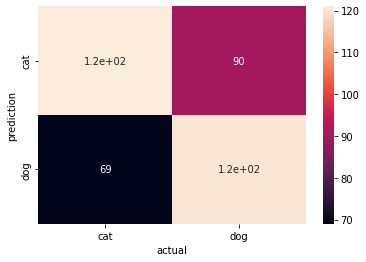

In [ ]:
# Create confusion matrix

confusion_matrix = pd.crosstab(data['prediction'], data['actual'], rownames=['prediction'], 
                               colnames=['actual'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()